This script is based on [Akamine et al. (2025)](https://osf.io/preprints/psyarxiv/7f6mu_v1).


# Overview processing steps
<img src="figures/dtw_pipeline.png" height=400 />

This markdown file contains the following processing steps.

1. Merge body and hands time series and apply linear interpolation, normalization, and smoothing (C--E)

2. Calculate finger tip positions relative to the wrist (F)

3. Trim the time series data for the gesture duration based on ELAN annotations (G)

4. Create a distance matrix with dynamic time warping distances between two gestures (H)

5. Compute DTW distance on flipped videos in case of mirrored gestures

# 0. Import packages & define directories

In [1]:
# loading in some basic packages
import numpy as np                           # basic data operations
import pandas as pd                          # data wrangling
import os                                    # for foldering       
import glob                                  # for file handling  
from tqdm import tqdm                        # for progress bars
from scipy.ndimage import gaussian_filter1d  # for smoothing
from scipy.spatial import distance
import matplotlib.pyplot as plt              # for plotting
from scipy.stats import pearsonr, spearmanr  # for correlation
import statsmodels.formula.api as smf        # for linear regression
from warnings import simplefilter            # for ignoring warnings
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# loading custom-made functions
from functions import (preprocess_ts, fill_missing_values, normalize_size, 
                       normalize_position, adjust_aspect_ratio, flip_y_axis, 
                       export_merge_annot)
from dtw_functions import get_keypoints, get_relative_keypoints, make_export_dtw_df

# initializing some folders and files
timeseries_folder = "../data/mediapipe/output_timeseries/"
flipped_timeseries_folder = "../data/mediapipe/output_timeseries_flipped/"
# list of all the folders in the time series folder
ts_folders = os.listdir(timeseries_folder)
ts_folders_flipped = os.listdir(flipped_timeseries_folder)

anno_path = "../data/elan_annotation/"
processed_folder = "../data/processed/"
merged_folder = processed_folder + "01_merged_ts/"
interpolated_folder = processed_folder + "02_interpolated_ts/"
norm_smooth_folder = processed_folder + "03_normalized_and_smoothed_ts/"
ts_annot_folder = processed_folder + "04_ts_aligned_gesture/"
ts_annot_folder_flipped = ts_annot_folder + "flipped/"
dtw_folder = processed_folder + "05_dtw_distance/"

# setting up autoreload for interactive development
%load_ext autoreload
%autoreload 2

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# 1. Preprocess MediaPipe time series

We will perform the following preprocessing on the timeseries data:

1. merge body and hands time series data into one pandas dataframe
2. interpolate the missing values
3. apply smoothing
4. normalize for size and position
5. adjust for aspect ratio
6. flip y axis

**Why do we interpolate missing values?**

Sometimes, mediapipe fails to estimate the location of a joint and returns no value. This leads to timeseries data with missing values or NaNs and can cause errors when computing distance using DTW.

To tackle this, we will fill missing values based on the most adjacent values for the particular keypoint. For example, imagine that the "X_LEFT_THUMB_TIP" consisted of 5 missing values like this: 0.5, 0.4, NaN, NaN, NaN, NaN, NaN, -0.2. In this case, we will fill the NaNs in a way that the value immediately before the first NaN and the one immediately after the last NaN are equally distanced, like this: 0.5, 0.4, 0.3, 0.2, 0.1, 0, -0.1, -0.2. This can offer a reasonable estimate for where the hand was for the missing points.

**Why do we smooth the data?**

We will apply smoothing because most likely, there will be noise-related jitter in the time series data.

**Why do we normalize for size and position?**

We normalize size and position to ensure a consistent representation of poses across different frames and individuals. In other words, normalization reduces noise in the data caused by variation in the location of participant. 

Consider a case where in one video (video A) a participant is standing on the left of the video at 1m from the camera and in another video (video B) the same participant is standing on the right side at 2m from the camera. In this case, values for x-axis is (almost) always lower for video A because of the participant appears on the left in video A while they appear on the right in video B. In addition, the same movements look bigger in video B because the participant is closer to the camera. In this case, applying size and position normalization can "move" the participant to the center of the video so that the difference in standing position does not affect timeseries data.

**Why do we adjust for aspect ratio and flip y-axis?**

We adjust the values for x- and y-axis to align the unit size for x and y. For example, for a video with 16:9 aspect ratio (e.g., 1920:1080), if moving a hand 5 cm horizontally corresponds to 0.1 in x, moving a hand 5 cm vertically corresponds to about 0.18 in y. This difference arises because although the width of video is larger than the height, the range of MediaPipe unit is 0 to 1 for both x and y.

In addition, we will flip the y-axis because mediapipe output unit for y-axis is conterintuitve: 0 means top and 1 means bottom of the frame.

In [3]:
#load in data
ts_file_list = [timeseries_folder + file_name + "/" + file_name for file_name in ts_folders if file_name not in [".DS_Store", "._.DS_Store", ".gitkeep"]]
ts_file_flipped_list = [flipped_timeseries_folder + file_name + "/" + file_name for file_name in ts_folders_flipped if file_name not in [".DS_Store", "._.DS_Store", ".gitkeep"]]
count_files = len(ts_file_list)
skip_count = 0
existing_files = []
body_cols_to_keep = ["time", 
                     "X_LEFT_SHOULDER", "Y_LEFT_SHOULDER", "Z_LEFT_SHOULDER",
                     "X_RIGHT_SHOULDER", "Y_RIGHT_SHOULDER", "Z_RIGHT_SHOULDER",
                     "X_LEFT_HIP", "Y_LEFT_HIP", "Z_LEFT_HIP",
                     "X_RIGHT_HIP", "Y_RIGHT_HIP", "Z_RIGHT_HIP"]

### preprocess the time series
for file in tqdm(ts_file_list):
    filename = file.split("/")[-1]
    if os.path.exists(norm_smooth_folder + filename + "_ns.csv"):
        skip_count += 1
        existing_files.append(file)
        continue

    ### preprocess the time series
    preprocess_ts(file, body_cols_to_keep, merged_folder, interpolated_folder, norm_smooth_folder)

### preprocess the flipped time series
for file in tqdm(ts_file_flipped_list):
    filename = file.split("/")[-1]
    if os.path.exists(norm_smooth_folder + "flipped/" + filename + "_ns.csv"):
        skip_count += 1
        existing_files.append(file)
        continue

    ### preprocess the time series
    preprocess_ts(file, body_cols_to_keep, merged_folder, interpolated_folder, norm_smooth_folder, flipped = True)

if skip_count > 0:
    print(f"Skipped {skip_count} files that already exist in the normalized and smoothed folder.")
    print(existing_files)

100%|██████████| 30/30 [00:00<00:00, 293.79it/s]

Skipped 90 files that already exist in the normalized and smoothed folder.
['../data/mediapipe/output_timeseries/001_a/001_a', '../data/mediapipe/output_timeseries/001_b/001_b', '../data/mediapipe/output_timeseries/002_a/002_a', '../data/mediapipe/output_timeseries/002_b/002_b', '../data/mediapipe/output_timeseries/003_a/003_a', '../data/mediapipe/output_timeseries/003_b/003_b', '../data/mediapipe/output_timeseries/005_a/005_a', '../data/mediapipe/output_timeseries/005_b/005_b', '../data/mediapipe/output_timeseries/006_a/006_a', '../data/mediapipe/output_timeseries/006_b/006_b', '../data/mediapipe/output_timeseries/007_a/007_a', '../data/mediapipe/output_timeseries/007_b/007_b', '../data/mediapipe/output_timeseries/008_a/008_a', '../data/mediapipe/output_timeseries/008_b/008_b', '../data/mediapipe/output_timeseries/009_a/009_a', '../data/mediapipe/output_timeseries/009_b/009_b', '../data/mediapipe/output_timeseries/010_a/010_a', '../data/mediapipe/output_timeseries/010_b/010_b', '../da

### Example illustrating the effect of interpolation, smoothing, and normalization.

In [4]:
ex_original = pd.read_csv(merged_folder + "030_b_merged.csv")
ex_original = ex_original[(ex_original["time"] >= 305000) & (ex_original["time"] <= 310000)]

ex_interpolated = fill_missing_values(ex_original.copy())

xyz_cols = [col for col in ex_interpolated.columns if col.startswith("X_") or col.startswith("Y_") or col.startswith("Z_")]
ex_smoothed = ex_interpolated[xyz_cols].apply(lambda x: gaussian_filter1d(x, sigma = 2))
ex_smoothed.insert(0, 'time', ex_interpolated["time"])

ex_normalized = normalize_size(ex_smoothed.copy())
ex_normalized = normalize_position(ex_normalized)
ex_normalized = adjust_aspect_ratio(ex_normalized)
ex_normalized = flip_y_axis(ex_normalized)

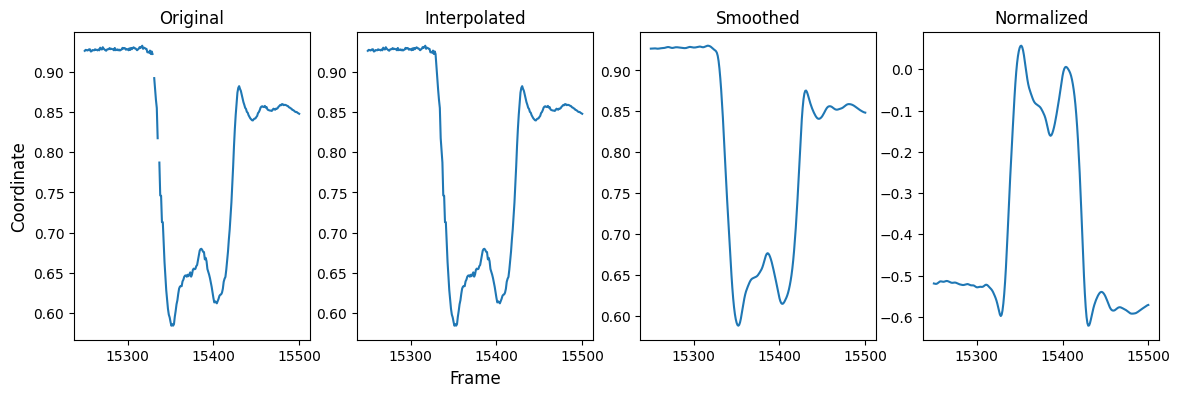

In [5]:
# Create a figure with two subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14, 4))

ax1.plot(ex_original[["Y_LEFT_WRIST"]])
ax1.set_title("Original")
ax1.set_ylabel("Coordinate", fontsize=12)

ax2.plot(ex_interpolated[["Y_LEFT_WRIST"]])
ax2.set_title("Interpolated")
ax2.set_xlabel("Frame", fontsize=12)

ax3.plot(ex_smoothed[["Y_LEFT_WRIST"]])
ax3.set_title("Smoothed")

ax4.plot(ex_normalized[["Y_LEFT_WRIST"]])
ax4.set_title("Normalized")

fig.savefig("figures/normalization_smoothing.png", dpi = 300)

As can be seen in the second plot, the missing values are interpolated linearly. Of course this is not a perfectly accurate estimates for the missing values, but we will use it as a good-enough approximation.

Based on the last figure, it looks like the smoothing was applied successfully. Note that the plot looks fliped because we flipped the y-axis for enhanced intellibility.

# 2 & 3. Calculate relative finger positions and trim ts data

### Preprocess ELAN files
Here, we will preprocess all ELAN annotation files

In [6]:
annots = os.listdir(anno_path)

# load in the annotations for gesture similarity coding
for anno_filename in annots:
    if anno_filename.endswith(".csv") and "processed" not in anno_filename:
        output_file = anno_path + anno_filename.split(".csv")[0] + "_processed.csv"
        if os.path.exists(output_file):
            print("File already exists: " + output_file)
            continue
        anno = pd.read_csv(anno_path + anno_filename)
        # create a comparison_id column that starts from 1 and increments by 1. This will be used when computing the distance matrix using DTW
        anno["comparison_id"] = anno.index + 1

        ### make a new column and fill it with the adjusted duration for gestures that are less than 330 milliseconds
        anno["begin_time_1_adj"] = np.where(anno["duration_1"] < 330, 
                                            anno["begin_time_1"] + (anno["duration_1"] - 330)/2, anno["begin_time_1"])
        anno["end_time_1_adj"] = np.where(anno["duration_1"] < 330,
                                            anno["end_time_1"] - (anno["duration_1"] - 330)/2, anno["end_time_1"])
        anno["duration_1_adj"] = anno["end_time_1_adj"] - anno["begin_time_1_adj"]
        anno["begin_time_2_adj"] = np.where(anno["duration_2"] < 330, 
                                            anno["begin_time_2"] + (anno["duration_2"] - 330)/2, anno["begin_time_2"])
        anno["end_time_2_adj"] = np.where(anno["duration_2"] < 330,
                                            anno["end_time_2"] - (anno["duration_2"] - 330)/2, anno["end_time_2"])
        anno["duration_2_adj"] = anno["end_time_2_adj"] - anno["begin_time_2_adj"]
        
        ### make a new column for handedness to decide for which hand(s) the distance should be calculated
        anno["A_hands"] = np.where((anno["A_LH_gesture_referent_1"].notna() | anno["A_LH_gesture_referent_2"].notna()) & 
                                    (anno["A_RH_gesture_referent_1"].notna() | anno["A_RH_gesture_referent_2"].notna()), "both", 
                                        np.where(anno["A_LH_gesture_referent_1"].notna() | anno["A_LH_gesture_referent_2"].notna(), "left",
                                            np.where(anno["A_RH_gesture_referent_1"].notna() | anno["A_RH_gesture_referent_2"].notna(), "right", None)))
        anno["B_hands"] = np.where((anno["B_LH_gesture_referent_1"].notna() | anno["B_LH_gesture_referent_2"].notna()) &
                                    (anno["B_RH_gesture_referent_1"].notna() | anno["B_RH_gesture_referent_2"].notna()), "both",
                                        np.where(anno["B_LH_gesture_referent_1"].notna() | anno["B_LH_gesture_referent_2"].notna(), "left",
                                            np.where(anno["B_RH_gesture_referent_1"].notna() | anno["B_RH_gesture_referent_2"].notna(), "right", None)))
        # A & B both -> both; A left & B right -> left_right; A right & B left -> right_left; A left & B left -> left; A right & B right -> right
        anno["hands_dtw"] = np.where((anno["A_hands"].str.endswith("left")) & (anno["B_hands"].str.endswith("left")), "left",
                                        np.where((anno["A_hands"].str.endswith("right")) & (anno["B_hands"].str.endswith("right")), "right", 
                                            np.where((anno["A_hands"].str.endswith("left")) & (anno["B_hands"].str.endswith("right")), "left_right",
                                                np.where((anno["A_hands"].str.endswith("right")) & (anno["B_hands"].str.endswith("left")), "right_left", "both"))))

        anno.to_csv(output_file, index=False)

        anno[['comparison_id', 'begin_time_1', 'end_time_1', 'begin_time_2', 'end_time_2',
            'duration_1', 'duration_2', 'hands_dtw']].head()

File already exists: ../data/elan_annotation/gestural_alignment_processed.csv


### Calculate relative finger positions and export time series data for each aligned gesture

In [7]:
MT_files = glob.glob(norm_smooth_folder + "*.csv")
anno = pd.read_csv(anno_path + "gestural_alignment_processed.csv")

export_merge_annot(MT_files, anno, ts_annot_folder, adj_dur=True)

Number of comparisons: 1305


100%|██████████| 60/60 [00:09<00:00,  6.34it/s]

60 files skipped because they already exist
Files skipped: ['001_a', '001_b', '002_a', '002_b', '003_a', '003_b', '005_a', '005_b', '006_a', '006_b', '007_a', '007_b', '008_a', '008_b', '009_a', '009_b', '010_a', '010_b', '011_a', '011_b', '012_a', '012_b', '013_a', '013_b', '015_a', '015_b', '016_a', '016_b', '017_a', '017_b', '018_a', '018_b', '019_a', '019_b', '020_a', '020_b', '021_a', '021_b', '022_a', '022_b', '023_a', '023_b', '027_a', '027_b', '028_a', '028_b', '029_a', '029_b', '030_a', '030_b', '031_a', '031_b', '032_a', '032_b', '039_a', '039_b', '040_a', '040_b', '041_a', '041_b']


# 4. Compute DTW distance on the wrists and finger tips (NOT relative location)
Next, we will compute distance matrix for each gesture comparison pair (distance between gesture 1 and gesture 2) to measure (dis)similarity of two gestures.

It is important to note that DTW is sensitive to the value, pattern, and duration difference (only when the beginning and the ending of two ts are different).

There are a few things to note:

1. We perform symmetric (`symmetric2`) DTW, as it resulted in the highest correlation for our datasets. However, other methods, such as loose beginning & end constraints DTW, might work better for other datasets because it accounts for potential inaccuracy in segmentation. For more details about the befit of loose beginning and end, please see [this paper](https://ieeexplore.ieee.org/document/7837974).
1. We only use the DTW distance for gesturing hands when calculating the average distance.

In [142]:
keypoints = get_keypoints(original=False)
# relative_keypoints = get_relative_keypoints()
anno = pd.read_csv(anno_path + "gestural_alignment_processed.csv")
make_export_dtw_df(dtw_folder, ts_annot_folder, keypoints, anno)

100%|██████████| 2610/2610 [01:18<00:00, 33.41it/s] 


The follwing 1 files were skipped. The files might contain missing values for the keypoints or have too few datapoints.
['032_a_1273_left_right.csv']
(1304, 81)


## Evaluate DTW's performance
Now we have the DTW distance scores for each aligned gesture pair, let's check how well DTW's predictions correlate with human ratings of gesture form similarity.

In [8]:
df_sim = pd.read_csv("../data/similarity_coding_zoom.csv")
df_dtw = pd.read_csv(dtw_folder + "dtw_distance_original.csv")
# merge the two dataframes on comparison_id
df = df_sim.merge(df_dtw, on = "comparison_id")
# calculate cumulative similarity
df["cumulative_similarity"] = df[["location", "handshape", "orientation", "movement"]].sum(axis = 1)
# drop unnecessary columns
df = df[["comparison_id", "location", "handshape", "orientation", "movement", "cumulative_similarity", "average_distance"]]

df.head()

,comparison_id,location,handshape,orientation,movement,cumulative_similarity,average_distance
0,35,1,0,0,0,1,0.641664
1,48,3,4,4,3,14,0.367037
2,56,2,1,4,3,10,0.607502
3,63,4,4,1,0,9,0.346368
4,82,3,0,0,3,6,0.549114


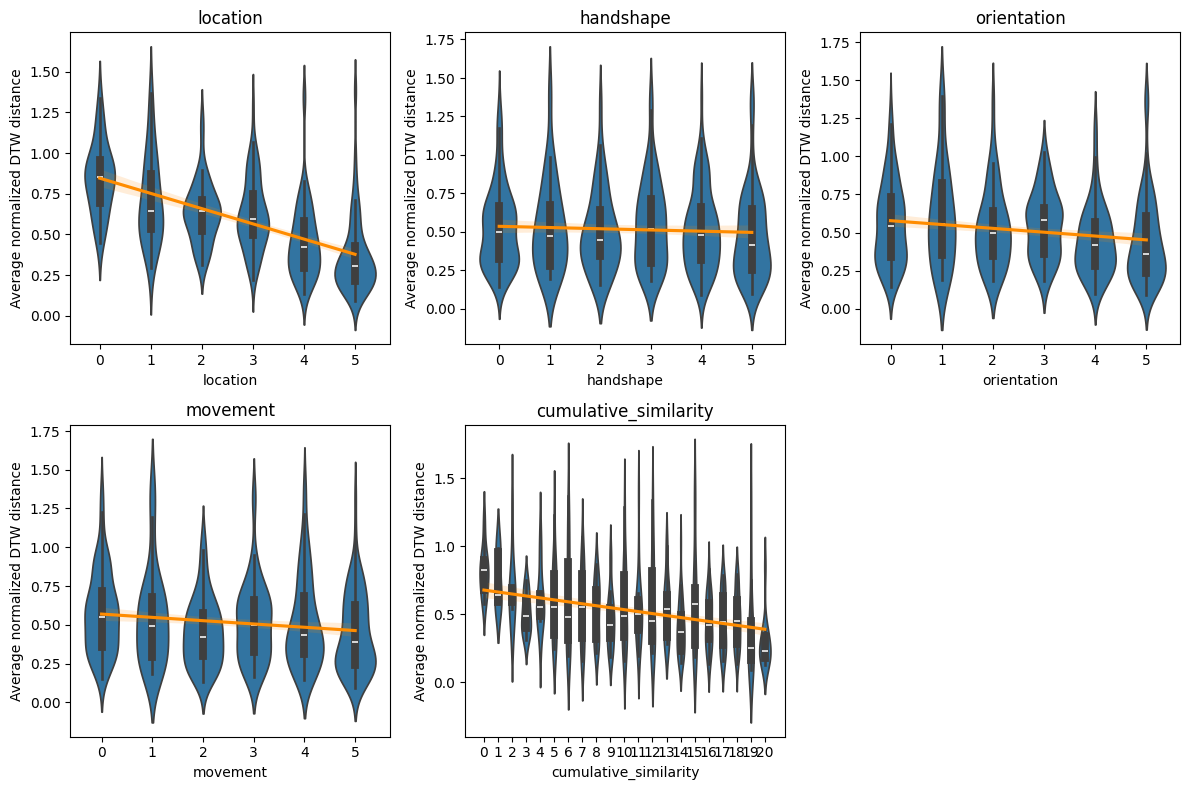

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

def plot_dtw_sim(fig, cols, rows, features, df, y="average_distance"):
    for i in range(len(features)):
        fig.add_subplot(rows, cols, i+1)
        fig.tight_layout()
        sns.violinplot(x=features[i], y=y, data=df)
        sns.regplot(x=features[i], y=y, data=df, scatter=False, color='darkorange')
        plt.title(features[i])
        plt.ylabel("Average normalized DTW distance")
    plt.show()

### plot the average distance for each feature
fig = plt.figure(figsize=(12, 8))
columns = 3
rows = 2
features = ["location", "handshape", "orientation", "movement", "cumulative_similarity"]
plot_dtw_sim(fig, columns, rows, features, df)

In [10]:
features = ["location", "handshape", "orientation", "movement"]

### linear regression
# m1 = smf.ols(f"average_distance ~ {"+".join(features)}", data=df)
# print(m1.fit().summary())

# m2 = smf.ols(f"average_distance ~ cumulative_similarity", data=df)
# print(m2.fit().summary())


### Correlations
for feature in features + ["cumulative_similarity"]:
    # pearson_corr, pearson_p = pearsonr(df[feature], df["average_distance"])
    spearman_corr, spearman_p = spearmanr(df[feature], df["average_distance"])
    # print(f"*{feature}*: Pearson correlation: {pearson_corr:.2f} (p = {pearson_p:.2f}), Spearman correlation: {spearman_corr:.2f} (p = {spearman_p:.2f})")
    print(f"*{feature}*: {spearman_corr:.2f} (p = {spearman_p:.2f})")

*location*: -0.57 (p = 0.00)
*handshape*: -0.08 (p = 0.13)
*orientation*: -0.20 (p = 0.00)
*movement*: -0.17 (p = 0.00)
*cumulative_similarity*: -0.31 (p = 0.00)


## Exercise 1
Does DTW predict gesture form similarity well for all features? What's captured best? Why do you think that particular feature is captured very well by DTW?

<br>

# 4.1 Run DTW on relative finger positions
One issue we observed in the previous analysis is that DTW is very sensitive to similarity in location, but not so much to other features. This means that location is currently weighted more than other features. This is likely because difference in location is penalized 6 times when running DTW on "raw" coordinates of finger tips (here, raw means preprocessed original time series data for finger tips, whose coordinates are NOT relative to the wrist locations).

Imagine a scenario where two speakers produced identical gestures---perfect alignment in handshape, orientation, and movement---but in difference positions. Ideally, we would get a very low DTW distance score, as only the location differs between the gestures. However, the current approach may return a high distance, because difference in location is not only reflected in the wrists coordinates but also in the coordinates of each finger tip. This means that difference in location is reflected in **6 keypoints**, giving more weights to location. See example below:

<img src="figures/relative_finger_position.svg" height=500 />


One solution to this is to calculate relative finger positions and compute DTW on the wrist and each finger tip. This way, only the wrists contain information about the location of the hands, and finger tips will not be affected by the difference in hand locations. We can comupte the relative location by `finger_tip_loc - wrist_loc`.

In [146]:
relative_keypoints = get_relative_keypoints()
anno = pd.read_csv(anno_path + "gestural_alignment_processed.csv")
make_export_dtw_df(dtw_folder, ts_annot_folder, relative_keypoints, anno)

100%|██████████| 2610/2610 [01:19<00:00, 32.98it/s] 


The follwing 1 files were skipped. The files might contain missing values for the keypoints or have too few datapoints.
['032_a_1273_left_right.csv']
(1304, 81)


## Evaluate DTW's performance
Let's check if using relative finger positions improved DTW's sensitivity to other features.

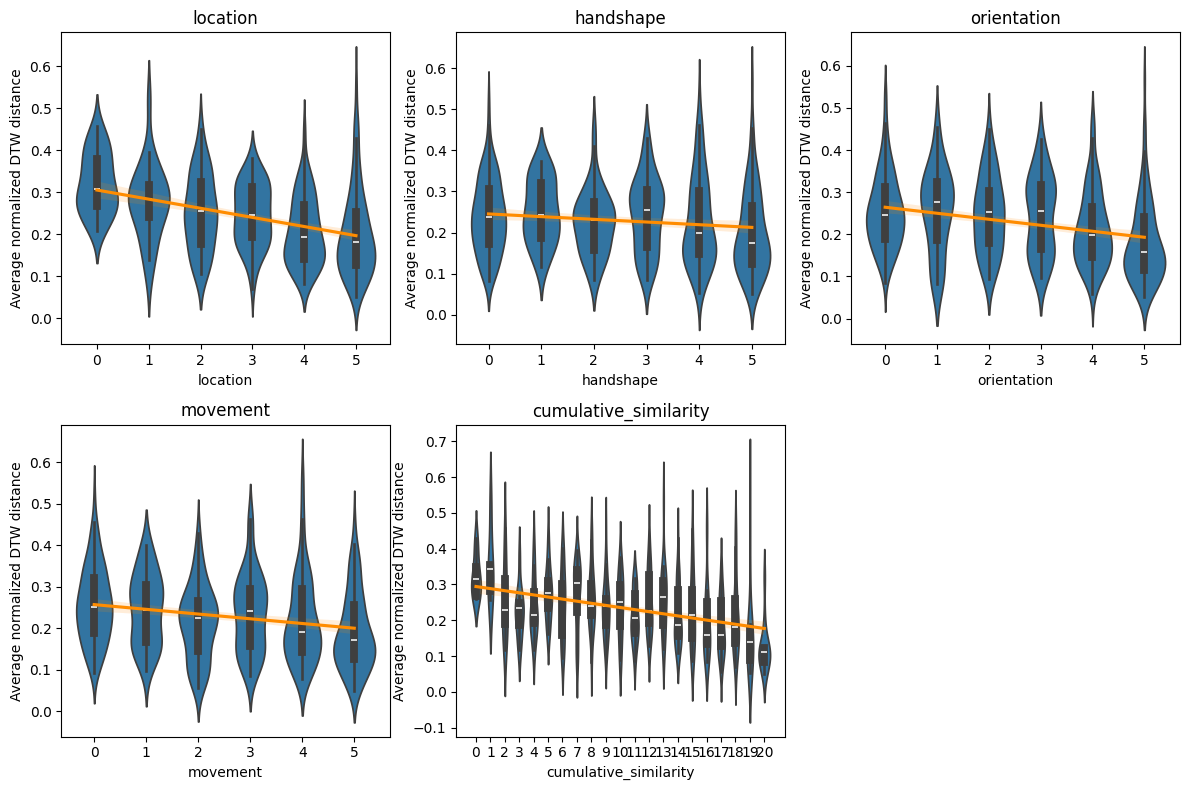

In [11]:
df_sim = pd.read_csv("../data/similarity_coding_zoom.csv")
df_dtw = pd.read_csv(dtw_folder + "dtw_distance.csv")
# merge the two dataframes on comparison_id
df = df_sim.merge(df_dtw, on = "comparison_id")
# calculate cumulative similarity
df["cumulative_similarity"] = df[["location", "handshape", "orientation", "movement"]].sum(axis = 1)
# drop unnecessary columns
df = df[["comparison_id", "location", "handshape", "orientation", "movement", "cumulative_similarity", "average_distance"]]


### plot the average distance for each feature
fig = plt.figure(figsize=(12, 8))
columns = 3
rows = 2
features = ["location", "handshape", "orientation", "movement", "cumulative_similarity"]
plot_dtw_sim(fig, columns, rows, features, df)

In [148]:
features = ["location", "handshape", "orientation", "movement"]

### Correlations
for feature in features + ["cumulative_similarity"]:
    # pearson_corr, pearson_p = pearsonr(df[feature], df["average_distance"])
    spearman_corr, spearman_p = spearmanr(df[feature], df["average_distance"])
    # print(f"*{feature}*: Pearson correlation: {pearson_corr:.2f} (p = {pearson_p:.2f}), Spearman correlation: {spearman_corr:.2f} (p = {spearman_p:.2f})")
    print(f"*{feature}*: {spearman_corr:.2f} (p = {spearman_p:.2f})")

*location*: -0.35 (p = 0.00)
*handshape*: -0.17 (p = 0.00)
*orientation*: -0.32 (p = 0.00)
*movement*: -0.25 (p = 0.00)
*cumulative_similarity*: -0.36 (p = 0.00)


## Exercise 2
1. Did the correlation improve for all features as well as cumulative similarity? What was the cost of changing from original finger coordinates to relative finger coordinates?

2. Is the correlation for cumulative similarity strong enough for DTW to be a useful proxy of gesture form similarity?

<br>

# 5. Improve prediction for mirrored gestures
There were some incongruent cases where DTW predicted a gesture to be dissimilar (i.e., high distance) but human annotators rated it as highly similar. After reviewing the video recordings of these cases, we found that the majority of these incongruent cases come from mirrored gestures.

This is because the current framework only maps speaker A's left hand to speaker B's left hand and A's right hand to B's right hand. To solve this issue, we will compute two DTW distances for one-handed gestures produced by different hands (e.g., A produced left-handed gesture and B produced right-handed gesture). One distance will be computed on the original videos, and the other one on speaker A's original video and speaker B's flipped video. Then we will take the smaller distance for the gesture.

In case of the example below, we will take the distance for the flipped one because its distance is smaller.

<img src="figures/dtw_example_mirrored.png" height=250 />


In [149]:
MT_files = glob.glob(norm_smooth_folder + "flipped/" + "*.csv")
anno = pd.read_csv(anno_path + "gestural_alignment_processed.csv")

export_merge_annot(MT_files, anno, ts_annot_folder_flipped, adj_dur=True)

Number of comparisons: 1305


100%|██████████| 30/30 [00:02<00:00, 12.48it/s]

30 files skipped because they already exist
Files skipped: ['001_b', '002_b', '003_b', '005_b', '006_b', '007_b', '008_b', '009_b', '010_b', '011_b', '012_b', '013_b', '015_b', '016_b', '017_b', '018_b', '019_b', '020_b', '021_b', '022_b', '023_b', '027_b', '028_b', '029_b', '030_b', '031_b', '032_b', '039_b', '040_b', '041_b']


In [150]:
relative_keypoints = get_relative_keypoints()
anno = pd.read_csv(anno_path + "gestural_alignment_processed.csv")
make_export_dtw_df(dtw_folder, ts_annot_folder, relative_keypoints, anno, use_mirrored_ts=True)

100%|██████████| 2610/2610 [01:25<00:00, 30.63it/s] 


The follwing 1 files were skipped. The files might contain missing values for the keypoints or have too few datapoints.
['032_a_1273_left_right.csv']
(1304, 81)


## Evaluate DTW's performance
Let's check if the modified pipeline improved the predictive accuracy of DTW

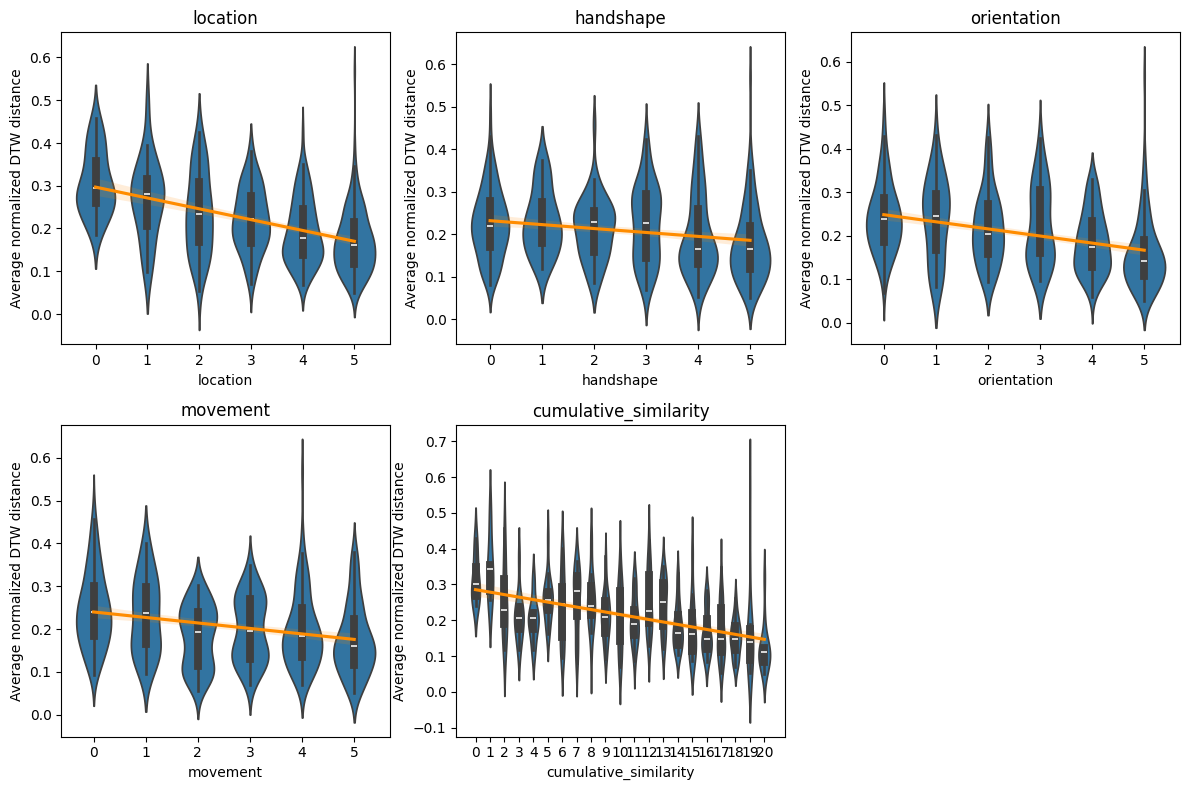

In [12]:
df_sim = pd.read_csv("../data/similarity_coding_zoom.csv")
df_dtw = pd.read_csv(dtw_folder + "dtw_distance_mirrored.csv")
# merge the two dataframes on comparison_id
df = df_sim.merge(df_dtw, on = "comparison_id")
# calculate cumulative similarity
df["cumulative_similarity"] = df[["location", "handshape", "orientation", "movement"]].sum(axis = 1)
# drop unnecessary columns
df = df[["comparison_id", "location", "handshape", "orientation", "movement", "cumulative_similarity", "average_distance"]]


### plot the average distance for each feature
fig = plt.figure(figsize=(12, 8))
columns = 3
rows = 2
features = ["location", "handshape", "orientation", "movement", "cumulative_similarity"]
plot_dtw_sim(fig, columns, rows, features, df)

In [152]:
features = ["location", "handshape", "orientation", "movement"]

### Correlations
for feature in features + ["cumulative_similarity"]:
    # pearson_corr, pearson_p = pearsonr(df[feature], df["average_distance"])
    spearman_corr, spearman_p = spearmanr(df[feature], df["average_distance"])
    # print(f"*{feature}*: Pearson correlation: {pearson_corr:.2f} (p = {pearson_p:.2f}), Spearman correlation: {spearman_corr:.2f} (p = {spearman_p:.2f})")
    print(f"*{feature}*: {spearman_corr:.2f} (p = {spearman_p:.2f})")

*location*: -0.42 (p = 0.00)
*handshape*: -0.24 (p = 0.00)
*orientation*: -0.40 (p = 0.00)
*movement*: -0.28 (p = 0.00)
*cumulative_similarity*: -0.45 (p = 0.00)


<br>

# Bonus: To what extent do two annotators agree with the ratings?
So far, we've looked at a correlation between DTW and a human annotator. However, with this information alone it's hard to state whether DTW is as good as humans in rating gesture form similarity or not. So let's compute a correlation between annotator 1 and 2.

In [13]:
df_sim1 = pd.read_csv("../data/similarity_coding_zoom.csv")
df_sim2 = pd.read_csv("../data/similarity_coding_zoom_sc.csv")

### merge the two dataframes on comparison_id
df = df_sim1.merge(df_sim2, on = "comparison_id", suffixes=('_sim1', '_sim2'))
# remove rows if any of the similarity columns have NaN values
df = df.dropna(subset=["location_sim1", "handshape_sim1", "orientation_sim1", "movement_sim1",
                    "location_sim2", "handshape_sim2", "orientation_sim2", "movement_sim2"])

### calculate cumulative similarity
df["cumulative_similarity_sim1"] = df[["location_sim1", "handshape_sim1", "orientation_sim1", "movement_sim1"]].sum(axis = 1)
df["cumulative_similarity_sim2"] = df[["location_sim2", "handshape_sim2", "orientation_sim2", "movement_sim2"]].sum(axis = 1)

### compute correlation for each feature between the two coders
features = ["location", "handshape", "orientation", "movement", "cumulative_similarity"]

for feature in features:
    pearson_corr, pearson_p = pearsonr(df[f"{feature}_sim1"], df[f"{feature}_sim2"])
    spearman_corr, spearman_p = spearmanr(df[f"{feature}_sim1"], df[f"{feature}_sim2"])
    print(f"*{feature}*: Pearson correlation: {pearson_corr:.2f} (p = {pearson_p:.2f}), Spearman correlation: {spearman_corr:.2f} (p = {spearman_p:.2f})")

*location*: Pearson correlation: 0.64 (p = 0.00), Spearman correlation: 0.61 (p = 0.00)
*handshape*: Pearson correlation: 0.70 (p = 0.00), Spearman correlation: 0.72 (p = 0.00)
*orientation*: Pearson correlation: 0.52 (p = 0.00), Spearman correlation: 0.53 (p = 0.00)
*movement*: Pearson correlation: 0.61 (p = 0.00), Spearman correlation: 0.63 (p = 0.00)
*cumulative_similarity*: Pearson correlation: 0.73 (p = 0.00), Spearman correlation: 0.74 (p = 0.00)


<br>

# Conclusion
This coding module demonstrated that DTW can serve a rough, but useful proxy for gesture form similarity. Although it's predictive accuracy is not as good as human annotators, its efficiency and applicability for large-scale dataset makes it an invaluable approach to quantifying gesture form similarity. Here, I'll summarize the strengths and weaknesses of DTW and list some future directions:

**Strengths**
- it quantifies the *degree* of (dis)similarity, unlike typical binary coding done in manual coding
- it's very efficient
- it can easily be scaled up to large sample size

**Weaknesses**
- it cannot classify the features in which two gestures are similar
- its predictive accuracy is not as high as human annotators
- kinematic analyses involve a steep learning curve

**Future directions**
- improve the predictive accuracy
- modify the pipeline so that DTW can classify the overlapping features
